In [ ]:
# install packages
import sys
!{sys.executable} -m pip install networkx
!{sys.executable} -m pip install matplotlib
!{sys.executable} -m pip install numpy

In [2]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

In [3]:
def BFS(adjacency_dict, target):
    visited_bfs = [1]
    next_layer = [1]
    num_steps = 1
    while (len(next_layer) > 0):
        current_layer = next_layer
        next_layer = []

        for vertex in current_layer:
            
            for neighbor in adjacency_dict[vertex]:
                num_steps += 1
                if target[neighbor]:
                    
                    return neighbor, num_steps, visited_bfs
                else:
                    visited_bfs.append(neighbor)
                next_layer.append(neighbor)
    return None, num_steps, visited

In [4]:
def DFS(adjacency_dict, target, current = 1, visited_dfs = [1], backtrack = {}):
    """Perform depth first search for 'true' targets given adjacency dictionary"""
    print("current",current)
#     print("current",current)
#     print("visited",visited_dfs)
#     print("backtrack",backtrack)
    # if we have visited all vertices without finding a 'true' vertex, return None
    # This means there are no 'true' vertices in the graph
    if len(visited_dfs) == max(adjacency_dict):
        return None, len(visited_dfs), visited_dfs
    
    # Find all unvisited neighbors of current vertex
    unvisited_neighbors = [x for x in adjacency_dict[current] if x not in visited_dfs]
    
#     print("unvisited neighbors: {}\ncurrent: {}\nvisited: {}\nbacktrack: {}".format(unvisited_neighbors,current,visited_dfs,backtrack))
    # if there are no unvisited neighbors, every vertex "further down" in the tree has been searched
    # Backtrack to the previous vertex and perform DFS from there
    if len(unvisited_neighbors) == 0:
        try:
            return DFS(adjacency_dict, target, backtrack[current],visited_dfs,backtrack)
        except:
            print("unvisited neighbors: {}\ncurrent: {}\nvisited: {}\nbacktrack: {}".format(unvisited_neighbors,current,visited_dfs,backtrack))

    # choose an unvisited vertex, neighbor of the current vertex, to visit next
    next_vertex = min(unvisited_neighbors)

    # keep track of the edge between the current vertex and the next vertex so 
    # we can backtrack in the future if necessary
    backtrack[next_vertex] = current
    
    # if the next vertex is 'true', return it
    if target[next_vertex]:
        return next_vertex, len(visited_dfs), visited_dfs
    
    # if not, mark that the next vertex has been visited, and continue the algorithm from there
    visited_dfs.append(next_vertex)
    return DFS(adjacency_dict, target, next_vertex,visited_dfs,backtrack)

In [5]:

np.random.seed(123)
vertex_limit = 100
poisson_param = 3
p = 0.15
small_size = 25
large_size = 100
fig_size = 4

adjacency_dict = {1 : []}
count = 1
curr_vertex = 1
colors = ["dodgerblue"]
sizes = [100]
vertex_color = {1: "lightgreen", 0: "silver"}

vertex_size = {1: 100, 0: 25}
success_dict = {1 : True, 0 : False}
layer = 1
target = {1 : False}

layer_vertices = [1]
next_layer_vertices = []
layer = 1

close_solutions = False

while (count < vertex_limit):
#     if curr_vertex == 5:
#         break
    num_neighbors = np.random.poisson(lam=max(1,poisson_param - curr_vertex + 1)) + 1
    
    if curr_vertex in layer_vertices:

        next_layer_vertices += list(range(count + 1, count + 1 + num_neighbors))

    else:

        layer_vertices = next_layer_vertices
        next_layer_vertices = list(range(count + 1, count + 1 + num_neighbors))
        layer += 1
        
    for neighbor in range(num_neighbors):
        count += 1
                
        adjacency_dict[curr_vertex].append(count)
        adjacency_dict[count] = []
        
        if close_solutions:
            success = np.random.binomial(1, p**layer)
        else:
            success = np.random.binomial(1, p**(max(1,6 - layer)))

        target[count] = success_dict[success]
        colors.append(vertex_color[success])
        sizes.append(vertex_size[success])

    curr_vertex += 1

g = nx.Graph()
for v1, val in adjacency_dict.items():
    for v2 in val:
        g.add_edge(v1,v2,)
my_pos = nx.spring_layout(g, seed = 100)

In [6]:
layer

5

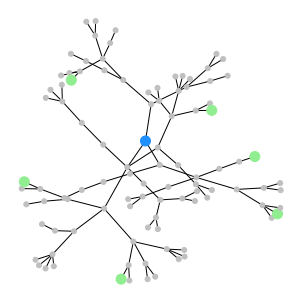

In [7]:
plt.figure(figsize=(fig_size,fig_size)) 
nx.draw(g, pos=my_pos, node_color = colors,node_size=sizes,with_labels=False)
plt.show()

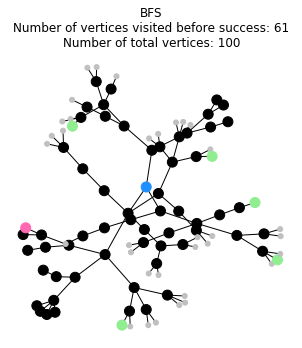

In [8]:
plt.figure(figsize=(fig_size,fig_size)) 

found_vertex, num_steps, visited = BFS(adjacency_dict, target)

BFS_colors = colors.copy()
BFS_sizes = sizes.copy()
for v in visited:
    if v != 1:
        BFS_colors[v-1] = "black"
        BFS_sizes[v - 1] = large_size
if found_vertex is not None:
    BFS_colors[found_vertex-1] = "hotpink"
nx.draw(g, pos=my_pos, node_color = BFS_colors, node_size = BFS_sizes)
plt.title("BFS\nNumber of vertices visited before success: {}\nNumber of total vertices: {}".format(num_steps,max(adjacency_dict)))
plt.show()

In [ ]:
plt.figure(figsize=(fig_size,fig_size)) 

found_vertex, num_steps, visited = DFS(adjacency_dict, target)

DFS_colors = colors.copy()
DFS_sizes = sizes.copy()
for v in visited:
    if v != 1:
        DFS_colors[v-1] = "black"
        DFS_sizes[v - 1] = large_size
if found_vertex is not None:
    DFS_colors[found_vertex-1] = "hotpink"
nx.draw(g, pos=my_pos, node_color = DFS_colors, node_size = DFS_sizes)
plt.title("DFS\nNumber of vertices visited before success: {}\nNumber of total vertices: {}".format(num_steps,max(adjacency_dict)))

plt.show()